In [1]:
## Import packages

from collections import OrderedDict

import numpy as np

import torch

from torch.utils.data import DataLoader
from torch.distributions import Normal

from eeyore.data import Iris
from eeyore.models import mlp
from eeyore.mcmc import MetropolisHastings, MALA, PowerPosteriorSampler

from timeit import default_timer as timer
from datetime import timedelta

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
## Avoid issuing memory warning due to number of plots

plt.rcParams.update({'figure.max_open_warning': 0})

In [3]:
## Load iris data

iris = Iris()
dataloader = DataLoader(iris, batch_size=150)

In [4]:
## Setup MLP model

hparams = mlp.Hyperparameters(dims=[4, 3, 3])
model = mlp.MLP(hparams=hparams)
model.prior = Normal(torch.zeros(model.num_params(), dtype=model.dtype), np.sqrt(3)*torch.ones(model.num_params(), dtype=model.dtype))

In [5]:
## Setup PowerPosteriorSampler

theta0 = model.prior.sample()
num_powers = 20
per_chain_samplers = num_powers * [['MALA', {'step': 0.05}]]

sampler = PowerPosteriorSampler(model, theta0, dataloader, per_chain_samplers)

In [6]:
## Run PowerPosteriorSampler

start_time = timer()

sampler.run(num_iterations=1100, num_burnin=100, between_step=1)

end_time = timer()
print("Time taken: {}".format(timedelta(seconds=end_time-start_time)))

Time taken: 0:02:32.121201


In [7]:
## Compute Monte Carlo mean

sampler.chains[num_powers-1].mean()

tensor([-0.2187, -1.4296, -1.2551, -0.0622,  0.8465,  1.2912, -1.0060, -1.1263,
        -1.0972, -0.9727, -0.2558, -0.1669,  0.7995,  1.1510,  0.7568,  0.4961,
         2.0594,  0.1945,  0.8368, -2.1421,  2.1320, -0.3961, -2.3832,  1.2507,
        -1.7355,  0.1170,  0.4757], dtype=torch.float64)

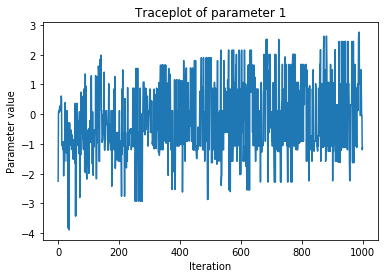

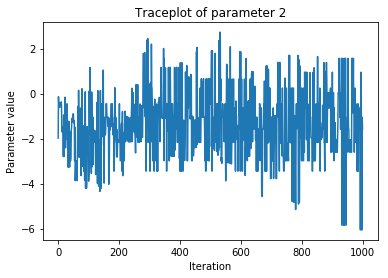

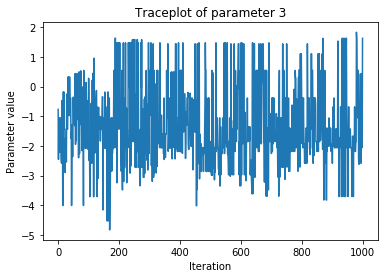

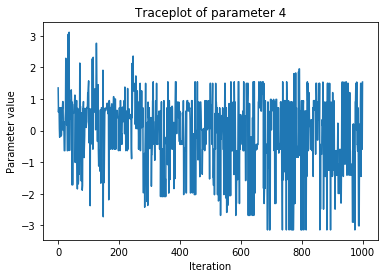

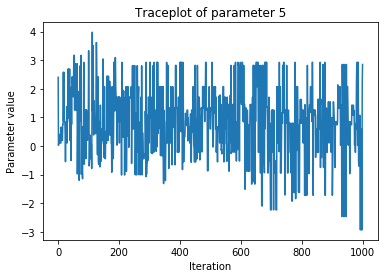

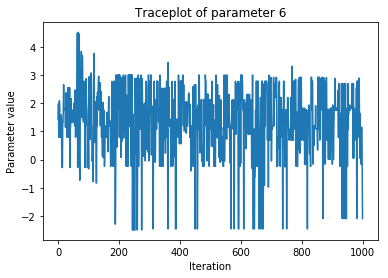

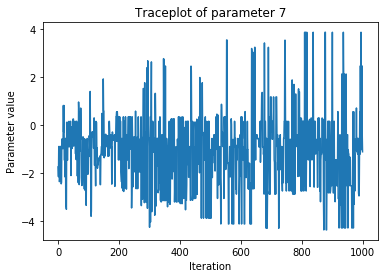

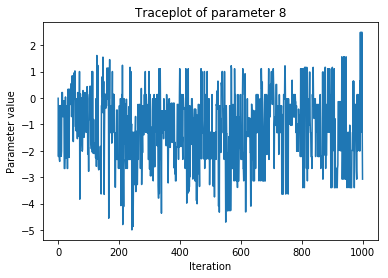

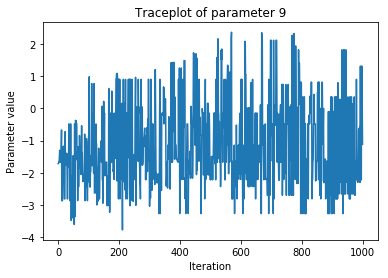

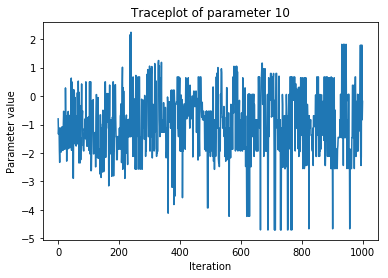

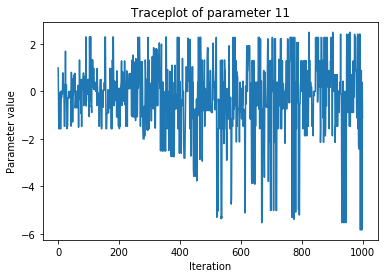

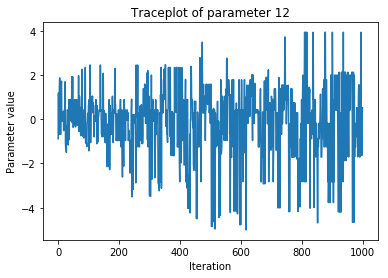

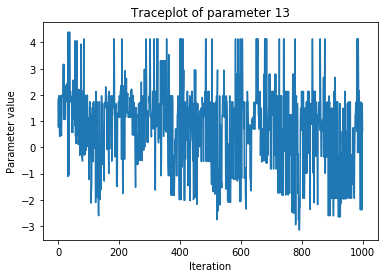

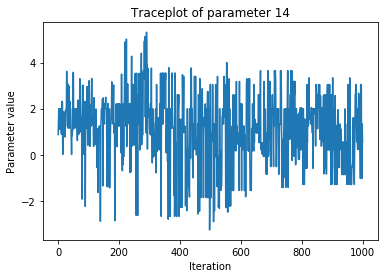

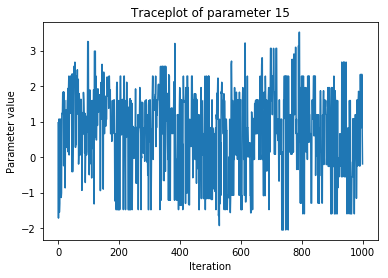

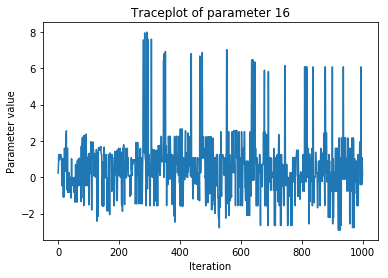

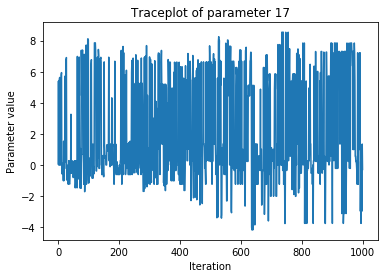

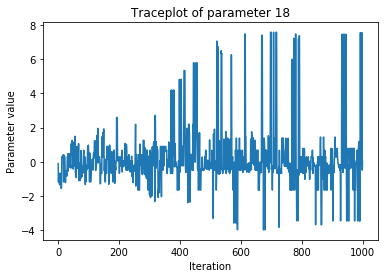

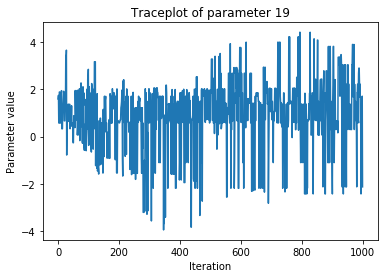

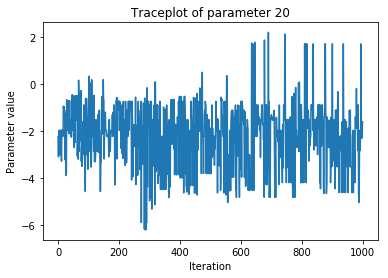

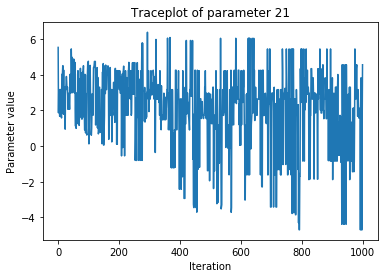

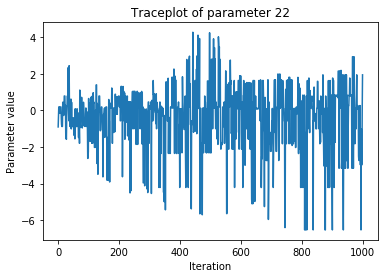

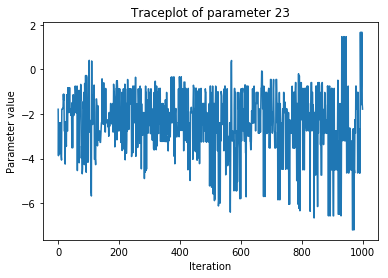

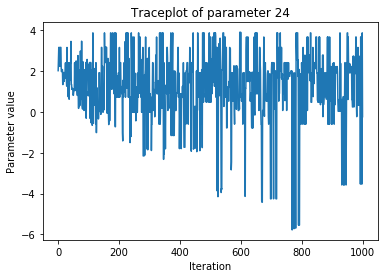

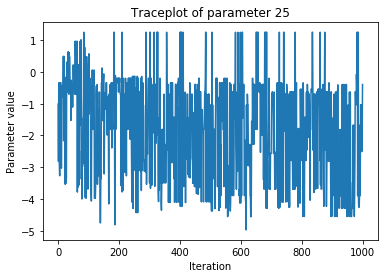

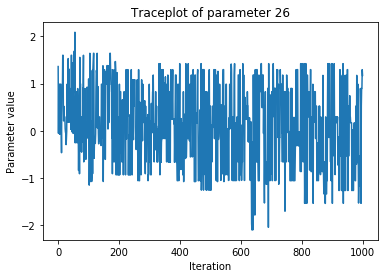

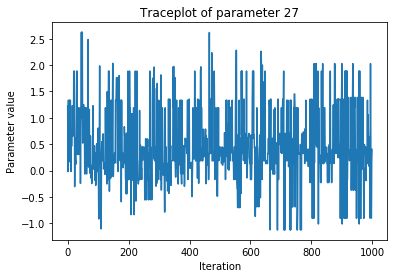

In [8]:
## Plot traces of simulated Markov chain

for i in range(sampler.models[num_powers-1].num_params()):
    chain = sampler.chains[num_powers-1].get_theta(i)
    plt.figure()
    sns.lineplot(range(len(chain)), chain)
    plt.xlabel('Iteration')
    plt.ylabel('Parameter value')
    plt.title(r'Traceplot of parameter {}'.format(i+1))